# Solving TFBI Linear Theory
The goal is to help you get started with using PlasmaCalcs to solve the linear theory of the Thermal Farley-Buneman Instability. **_Estimated time: 2-3 minutes_**

This notebook assumes you have already followed the instructions (see the README at https://gitlab.com/Sevans7/plasmacalcs) to install PlasmaCalcs on your machine.

Recommended: copy this notebook to somewhere on your machine (outside of the PlasmaCalcs package), then go through the cells one at a time!\
Use help(obj) for any object you want to know more about.

In [1]:
## imports ##
# builtins
import os   # for os.chdir to navigate to directory where data is stored.

# external packages available via pip install 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# PlasmaCalcs package
import PlasmaCalcs as pc


## optional / settings ##
import pdb   # --- after a crash, use pdb.pm() to enter the namespace of the crash, for easy debugging!

plt.rcParams['animation.html']='jshtml'  # enables in-line animations in Jupyter

from IPython.display import display, HTML  # set cell width in Jupyter:
display(HTML("<style>.container { width:90% !important; }</style>"))

# xarray options
xr.set_options(display_expand_data=False,
               keep_attrs=True, # -- keep attrs during operations. Note, doesn't handle conflicts, just takes attrs from the first array.
              );
# matplotlib options
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 70  # lower dpi for inline plots makes the Jupyter notebook file smaller.
# EDIT THAT DPI^ TO A LARGER NUMBER (e.g., 300, not 70) TO SEE HIGHER-RES IN-LINE PLOTS!

In [2]:
# force reload the PlasmaCalcs package.
#   Useful if you've made any changes but don't want to restart kernel.
#   Not required; you can delete this line if you are never editing PlasmaCalcs.
pc = pc.reload(pc)

# solve TFBI theory directly from eppic inputs
The inputs in this example match EPPIC-2a from [Evans+2025](https://doi.org/10.3847/1538-4357/adcd70)
and the main simulation from [Evans+2023](https://doi.org/10.3847/1538-4357/acc5e5)  
(except for simulation box size, which is set to be very small here)

(note: tfbi_theory outputs align +xhat with E, and assume B points out of the page)

In [3]:
with pc.InDir(pc.pc_path('tests', 'test_tfbi', 'test_tfbi_inputs')):
    ec = pc.EppicCalculator.from_here('eppic_2a_tinybox.i', u_t=1, kw_units=dict(M=1))  # EppicCalculator in SI units

In [4]:
ec.snap = pc.INPUT_SNAP   # get values from input deck, only (i.e., don't load values across space)

In [5]:
solver = ec.tfbi_solver()

In [6]:
dsR = solver.solve()

Completed 'solver.ds0 = EppicCalculator.tfbi_ds()' in 0.19 seconds!                                 
Completed 'calc_casc()' in 1.63 seconds!                                                            
Completed 'calc_parr() (given known casc)' in 0.83 seconds!                                         
Completed 'TfbiSolver.solve() (all steps from start to finish)' in 4.38 seconds!                    

In [7]:
dsR  # the result has lots of relevant values. The solution to TFBI theory is in dsR['omega']

<xarray.Dataset> Size: 4kB
Dimensions:          (fluid: 3, kmod_dim: 10, kang: 12, component: 2)
Coordinates:
    snap             object 8B INPUT_SNAP
    jfluid           object 8B neutral
  * fluid            (fluid) object 24B e- H+ C+
    kmod             (kmod_dim) float64 80B 0.006283 0.01793 ... 27.66 78.93
  * kang             (kang) float64 96B -1.309 -1.047 -0.7854 ... 1.309 1.571
  * component        (component) <U7 56B 'Ehat' '-ExBhat'
Dimensions without coordinates: kmod_dim
Data variables: (12/17)
    mod_B            float64 8B 0.001
    E_un0_perpmod_B  float64 8B 8.932
    kB               float64 8B 1.381e-23
    T_n              float64 8B 4e+03
    m_n              float64 8B 1.674e-27
    m                (fluid) float64 24B 9.109e-31 1.673e-27 1.99e-26
    ...               ...
    n                (fluid) float64 24B 3.6e+11 3e+11 6e+10
    eqperp_lmfp      (fluid) float64 24B 0.02064 0.008645 0.1358
    k                (component, kmod_dim, kang) float64 2kB 0.001626 ... 78.93
    omegau           float64 8B 1e+03
    ku               int64 8B 1
    omega            (kmod_dim, kang) complex128 2kB (39.64970069410798-0.001...

### plot the TFBI theory outputs

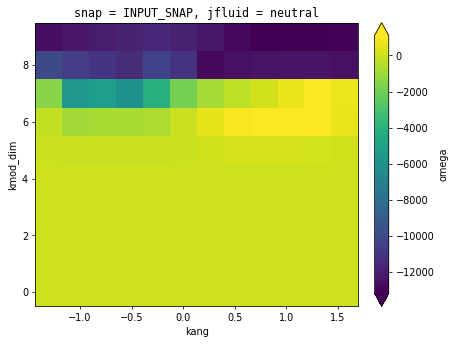

In [8]:
# SIMPLEST PLOTTING: dsR['omega'] is an array of omega vs |k| and angle(xhat, k).
dsR['omega'].imag.pc.image(aspect='auto');

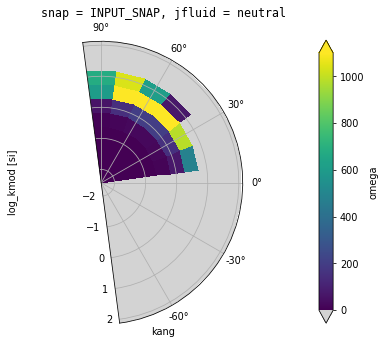

In [9]:
# let's make some plotting improvements:
dsR['omega'].imag.pc.image(y='log_kmod',  # log is easier to see because values are evenly-spaced in log-space
                           x='kang',
                           grid=True,
                           polar=True,  # polar makes it easier to under
                          vmin=0,  # <0 means no TFBI growth
                           cmap=pc.cmap('viridis', under='lightgray'),  # show values <vmin in gray.
                          );

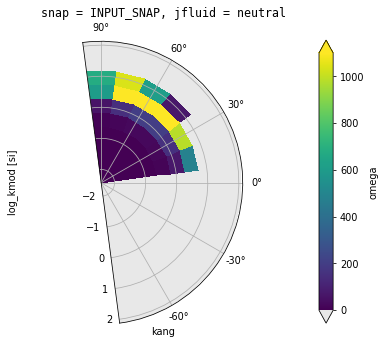

In [10]:
# PlasmaCalcs provides array.it.growthplot() as a shorthand to do similar formatting as above^
dsR['omega'].imag.it.growthplot();

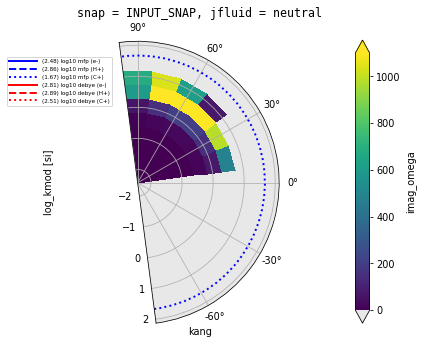

In [11]:
# applying .it.growthplot() directly to the dataset also draws "k lines" (unless you use klines=False).
# these indicate some important borders for where the TFBI theory can be trusted.
#   the theory starts becoming untrustworthy at k close to or larger than kmfp or kDebye,
#   since kinetic effects become important at length scales smaller than
#      collisional mean free path and debye length.
dsR.it.growthplot();

## Use different k inputs
The default k inputs are nice when solving across a wide range of physical parameters, but way sparser than necessary if solving across only 1 choice of parameters.  

**Let's use higher resolution for k.**

Also, the default |k| max cutoff is at 0.1 * min(kDebye_tot, kmfp_tot),  
where kDebye_tot^2 = sum_s kDebye_s^2, and kmfp_tot^2 = sum_s kmfp_s^2, for s in charged species. 

That cutoff is good to avoid including regions where the theory results are invalid due to kinetic effects.  
But it makes it harder to see how far away those regions truly are (e.g., how far out is kDebye, relative to the region being considered here?)

**Let's also extend |k| to larger values.**

In [12]:
solver = ec.tfbi_solver(kres='high', mod=dict(max=10**4))
dsR = solver.solve()

Completed 'solver.ds0 = EppicCalculator.tfbi_ds()' in 0.11 seconds!                                 
Completed 'calc_casc()' in 1.58 seconds!                                                            
Completed 'calc_parr() (given known casc)' in 1.28 seconds!                                         
Completed "TaskPartition(PolyMPArray applying to each poly: 'root_max_imag', ncoarse=10)" in 2.35 seconds!
Completed 'TfbiSolver.solve() (all steps from start to finish)' in 5.69 seconds!                    

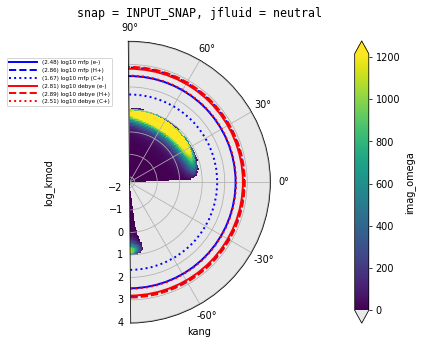

In [13]:
dsR.it.growthplot();

XarrayScatter([depth=1, height=0, size=1], obj=<PlasmaCalcs.plotting.scatter.ScatterPlotElement object at 0x7f99708fb940>)

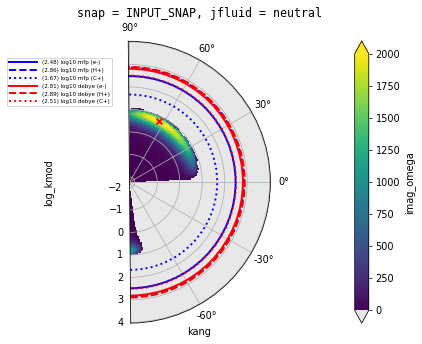

In [14]:
# it can be nice to put a marker at the max point,
# and change the vlims to reduce saturation at large values
xim = dsR.it.growthplot(vmax=2000)
xim.scatter_max()

# solve TFBI "sort of" from eppic inputs, but varying one of the parameters

E.g., it is very useful to vary E, to determine the threshold field.

The strategy here will be:
- load the dataset of relevant values from eppic
- scale some of those values / create an InstabilityCalculator (which takes a Dataset as input)
- solve TFBI theory using the InstabilityCalculator.tfbi_solver()

In [15]:
with pc.InDir(pc.pc_path('tests', 'test_tfbi', 'test_tfbi_inputs')):
    ec = pc.EppicCalculator.from_here('eppic_2a_tinybox.i', u_t=1, kw_units=dict(M=1))  # EppicCalculator in SI units

In [16]:
ec.snap = pc.INPUT_SNAP   # get values from input deck, only (i.e., don't load values across space)

In [17]:
solver = ec.tfbi_solver()

In [18]:
tfbivals0 = ec.tfbi_ds()   # other options include: ec('tfbi_inputs'), ec('tfbi_all')
tfbivals0

<xarray.Dataset> Size: 240B
Dimensions:          (fluid: 3)
Coordinates:
    snap             object 8B INPUT_SNAP
    jfluid           object 8B neutral
  * fluid            (fluid) object 24B e- H+ C+
Data variables: (12/13)
    mod_B            float64 8B 0.001
    E_un0_perpmod_B  float64 8B 8.932
    kB               float64 8B 1.381e-23
    T_n              float64 8B 4e+03
    m_n              float64 8B 1.674e-27
    m                (fluid) float64 24B 9.109e-31 1.673e-27 1.99e-26
    ...               ...
    skappa           (fluid) float64 24B -10.99 0.143 0.5964
    eqperp_ldebye    (fluid) float64 24B 0.009757 0.008032 0.01961
    eps0             float64 8B 8.854e-12
    abs_qe           float64 8B 1.602e-19
    n                (fluid) float64 24B 3.6e+11 3e+11 6e+10
    eqperp_lmfp      (fluid) float64 24B 0.02064 0.008645 0.1358

In [19]:
Etest = pc.xr1d([4, 6, 10, 20], 'E_test')
# ^shorthand for xr.DataArray([4, 6, 10, 20], coords={'E_test': [4, 6, 10, 20]}, name='E_test')
Etest

<xarray.DataArray 'E_test' (E_test: 4)> Size: 32B
4 6 10 20
Coordinates:
  * E_test   (E_test) int64 32B 4 6 10 20

In [20]:
tfbivals = tfbivals0.assign({'E_un0_perpmod_B': Etest})
cc = pc.InstabilityCalculator(tfbivals)

In [21]:
cc.tfbi_ds()   # (note: eqperp_ldebye & eqperp_lmfp got recomputed appropriately, using the new E.)

<xarray.Dataset> Size: 440B
Dimensions:          (E_test: 4, fluid: 3)
Coordinates:
    snap             object 8B INPUT_SNAP
    jfluid           object 8B neutral
  * E_test           (E_test) int64 32B 4 6 10 20
  * fluid            (fluid) object 24B e- H+ C+
Data variables: (12/13)
    mod_B            float64 8B 0.001
    E_un0_perpmod_B  (E_test) float64 32B 4.0 6.0 10.0 20.0
    kB               float64 8B 1.381e-23
    T_n              float64 8B 4e+03
    m_n              float64 8B 1.674e-27
    m                (fluid) float64 24B 9.109e-31 1.673e-27 1.99e-26
    ...               ...
    skappa           (fluid) float64 24B -10.99 0.143 0.5964
    eqperp_ldebye    (fluid, E_test) float64 96B 0.007836 0.008485 ... 0.02557
    eps0             float64 8B 8.854e-12
    abs_qe           float64 8B 1.602e-19
    n                (fluid) float64 24B 3.6e+11 3e+11 6e+10
    eqperp_lmfp      (fluid, E_test) float64 96B 0.01658 0.01795 ... 0.1771

In [22]:
solver = cc.tfbi_solver(kres='mid', mod=dict(min=10**-1, max=10**3.5))
dsR = solver.solve()

Completed 'solver.ds0 = InstabilityCalculator.tfbi_ds()' in 0.11 seconds!                           
Completed 'calc_casc()' in 1.57 seconds!                                                            
Completed 'calc_parr() (given known casc)' in 1.06 seconds!                                         
Completed 'TfbiSolver.solve() (all steps from start to finish)' in 4.97 seconds!                    

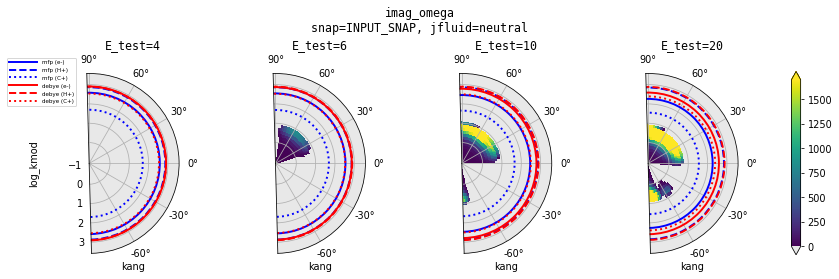

In [23]:
dsR.it.growthplots(share_vlims='all');  # share_vlims to use same colorbar for all plots

### Compute stuff from TFBI results

In [24]:
# let's make a calculator based on dsR and compute some things
cc2 = pc.InstabilityCalculator(dsR)
cc2

InstabilityCalculator(ds=Dataset with sizes={'E_test': 4, 'fluid': 3, 'kmod': 30, 'kang': 60, 'component': 3}))

In [25]:
cc2('growth_kmax')  # max growth rate (max taken across k) at each point

<xarray.DataArray 'growth_kmax' (E_test: 4)> Size: 32B
-0.1202 811.4 2.291e+03 3.557e+03
Coordinates:
    snap     object 8B INPUT_SNAP
    jfluid   object 8B neutral
  * E_test   (E_test) int64 32B 4 6 10 20

In [26]:
cc2('rad2deg_kang_at_growmax')  # angle [in degrees] of k where growth_kmax occurs

<xarray.DataArray 'rad2deg_kang_at_growmax' (E_test: 4)> Size: 32B
48.0 57.0 63.0 72.0
Coordinates:
    snap     object 8B INPUT_SNAP
    jfluid   object 8B neutral
    kang     (E_test) float64 32B 0.8378 0.9948 1.1 1.257
  * E_test   (E_test) int64 32B 4 6 10 20

In [27]:
cc2('kmod_at_growmax')  # |k| where growth_kmax occurs

<xarray.DataArray 'kmod_at_growmax' (E_test: 4)> Size: 32B
0.1 7.279 5.092 3.562
Coordinates:
    snap     object 8B INPUT_SNAP
    jfluid   object 8B neutral
    kmod     (E_test) float64 32B 0.1 7.279 5.092 3.562
  * E_test   (E_test) int64 32B 4 6 10 20

In [28]:
# for more info about available vars consider:
# cc2.help('')
# cc2.help('grow')
# cc2.help('max')